In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData, utils
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, Angle
import pandas
import warnings 
import copy
import utils
import hera_qm
from hera_mc import cm_hookup
#warnings.filterwarnings('ignore')

In [2]:
# get data location
data_path = os.environ['DATA_PATH']
JD = os.environ['JULIANDATE']


In [3]:
# Load in data
HHfiles, difffiles, uvdx, uvdy = utils.load_data(data_path,JD)

## Autocorrelations for a single file

This plot shows autocorrelations for one timestamp of each antenna that is active and each polarization

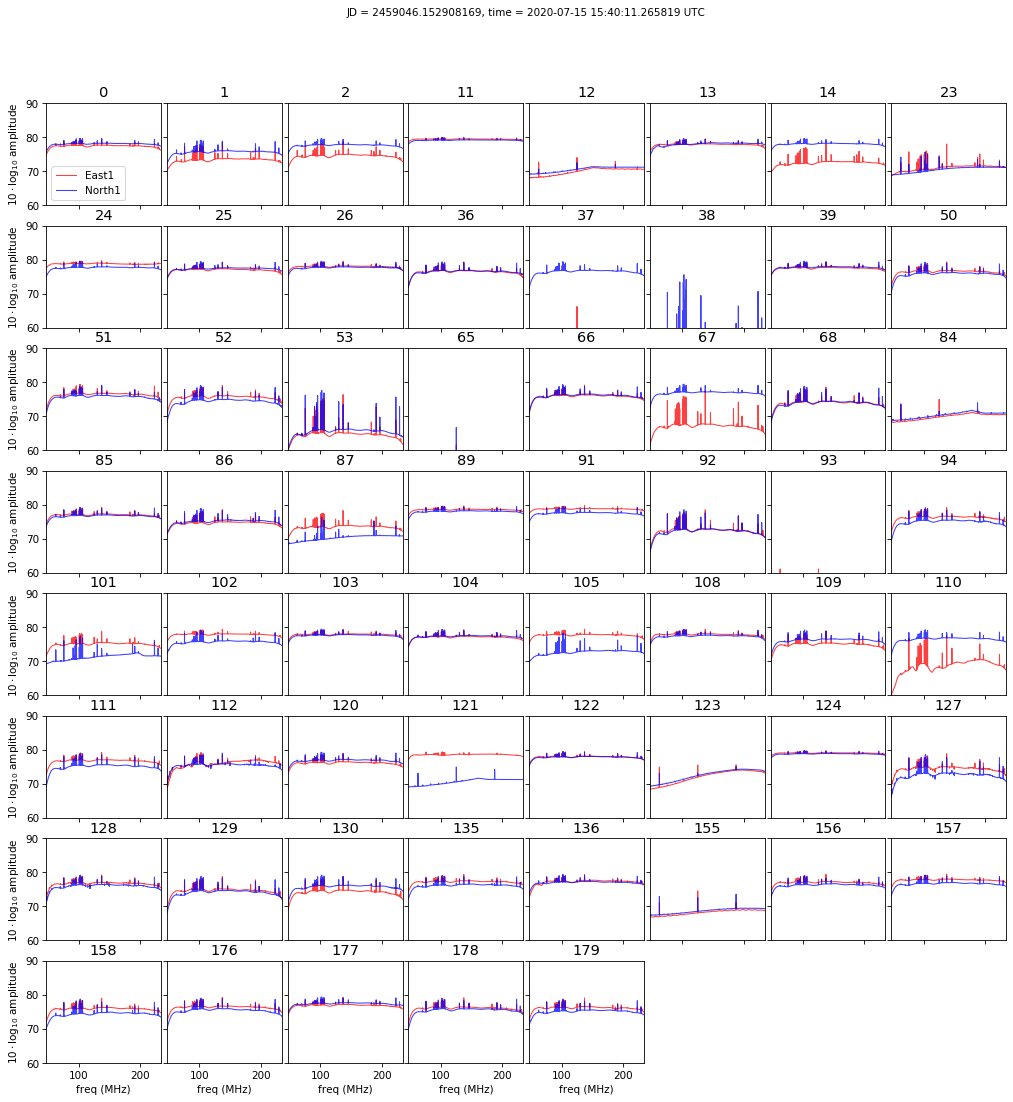

In [4]:
### plot autos
utils.plot_autos(uvdx, uvdy)

## Waterfalls of Autocorrelation Amplitudes for each Antenna and Each polarization

In [5]:
uvd = UVData()
uvd.read(HHfiles, ant_str = 'autos', skip_bad_files=True)

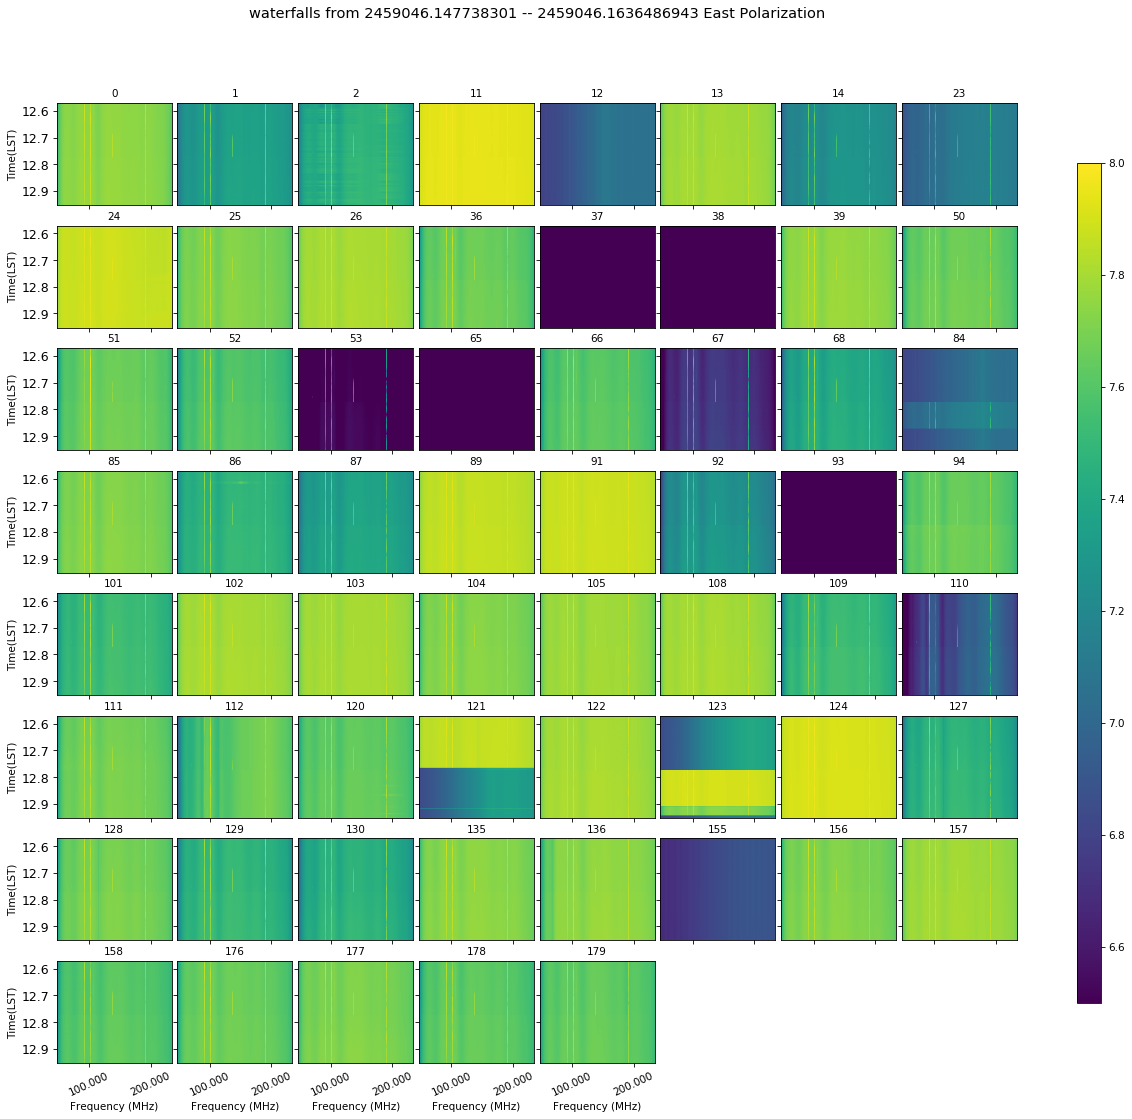

In [6]:
utils.plot_wfs(uvd, pol = 0)

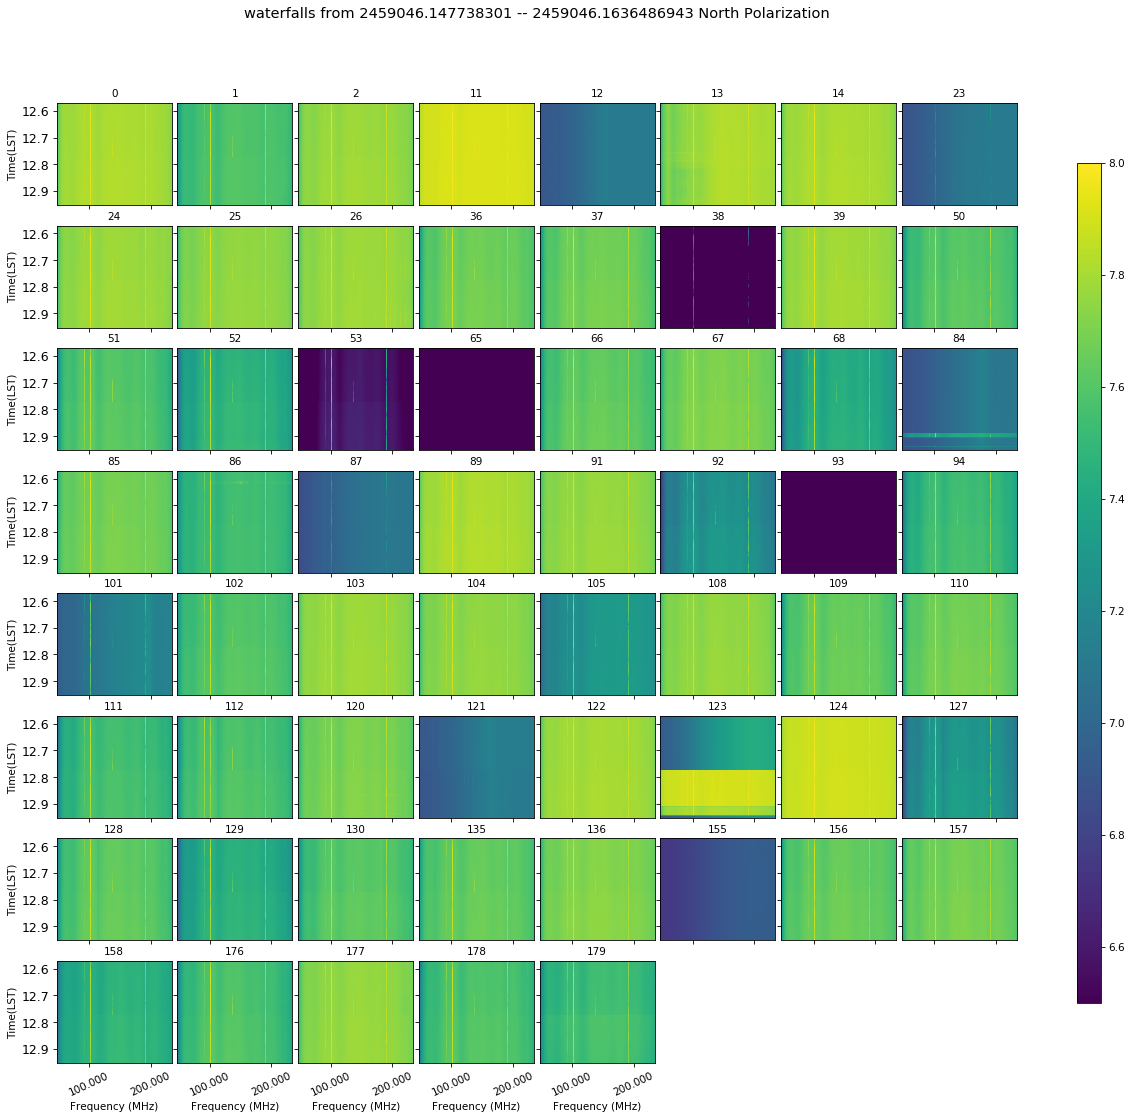

In [7]:
utils.plot_wfs(uvd, pol = 1)

## Correlation Metrics

The first plot shows the correlation metric (described below) for a set of baseline types, as calculated at several times throughout the night. It is expected that longer baselines (darker color) will exhibit lower values than the short baselines. 

The matrices show the phase correlation between antennas. Using the even and odd visibilities, each pixel is calculated as (even/abs(even)) * (conj(odd)/abs(odd)), and then averaged across time and frequency. If the phases are noise-like, this value will average down to zero. If the antennas are well correlated, the phases should not be noise-like, and this value should average to 1. The lines denoting node boundaries are intended to help confirm that inter-node correlations are functioning - if they aren't, this plot will appear block-diagonal.

This metric has shown to be LST locked - when comparing to other nights, be sure to compare for the same LST. It is expected that some LSTs will look much better or worse than others.

Note: Within each node, the order of antennas is determined by snap, and within that by snap input number. 

KeyError: '14m E-W'

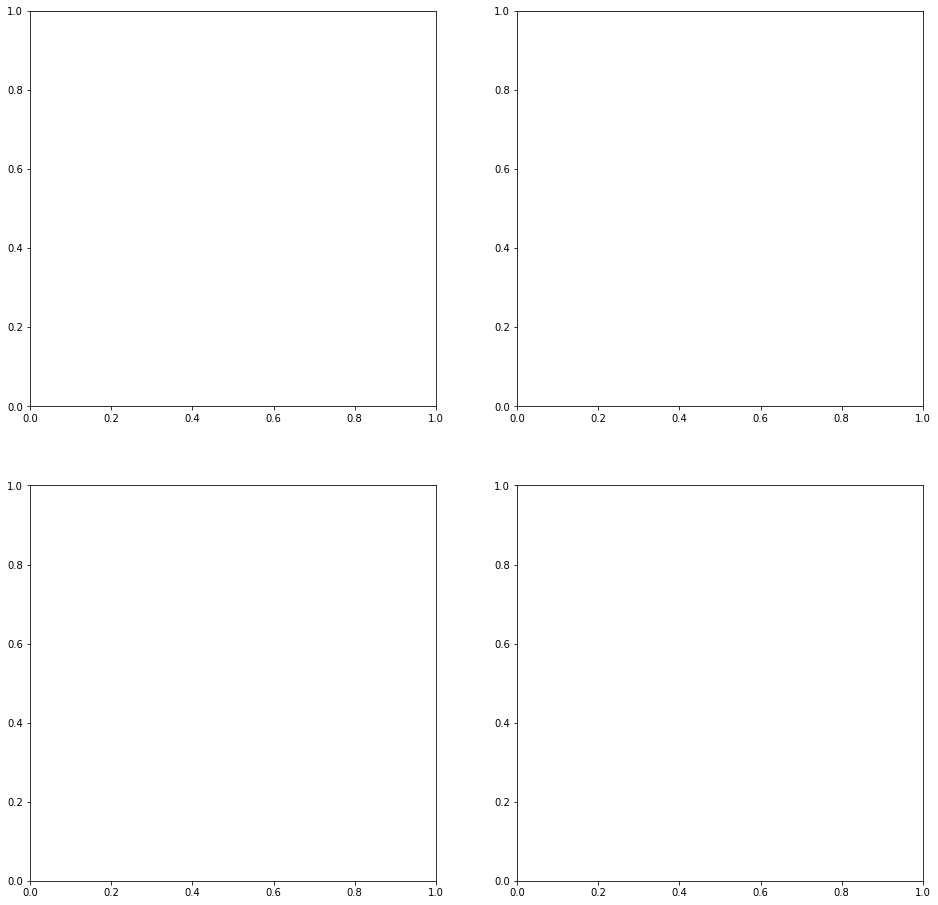

In [8]:
badAnts = []
badAnts = utils.plotNodeAveragedSummary(uvd,HHfiles,JD)

Visibility amplitude spectra for a set of redundant baselines, labeled by inter vs. intranode baselines. The red and blue should exhibit the same bandpass shape - if the red are consistently different from the blue, this indicates an issue with internode correlations.

Note: antennas that were identified as bad by the correlation matrix have been removed from this plot.

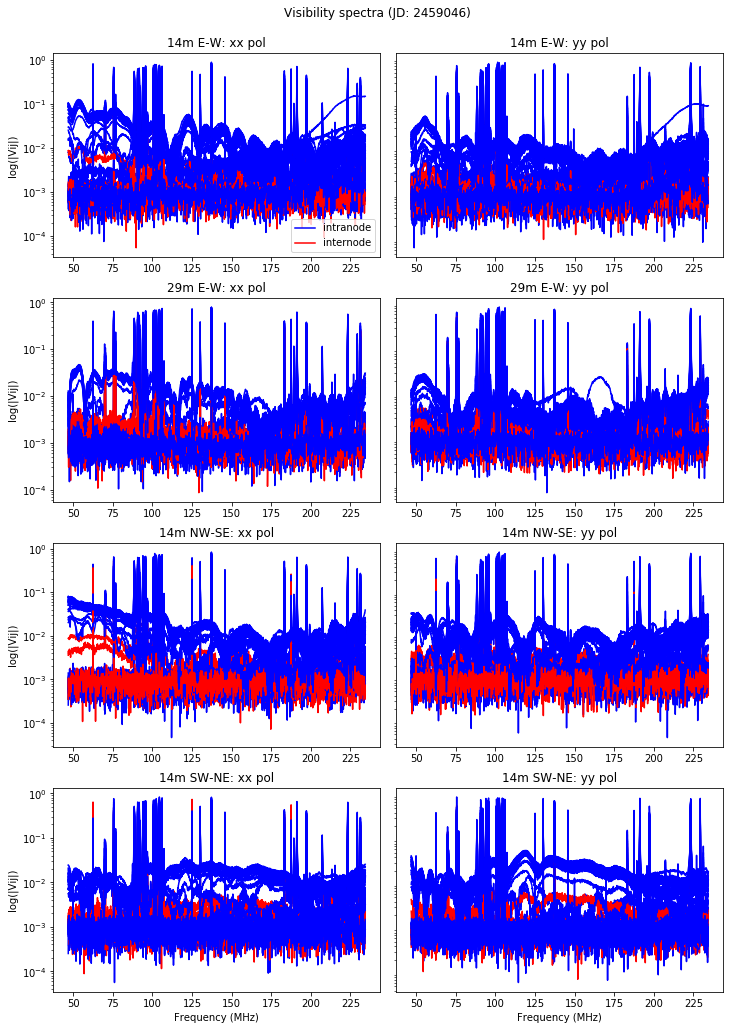

In [9]:
utils.plotVisibilitySpectra(HHfiles[len(HHfiles)//2], JD, badAnts=badAnts)

## Antenna Positions

Antennas outlined in black here have been identified by the correlation matrix as bad antennas. 

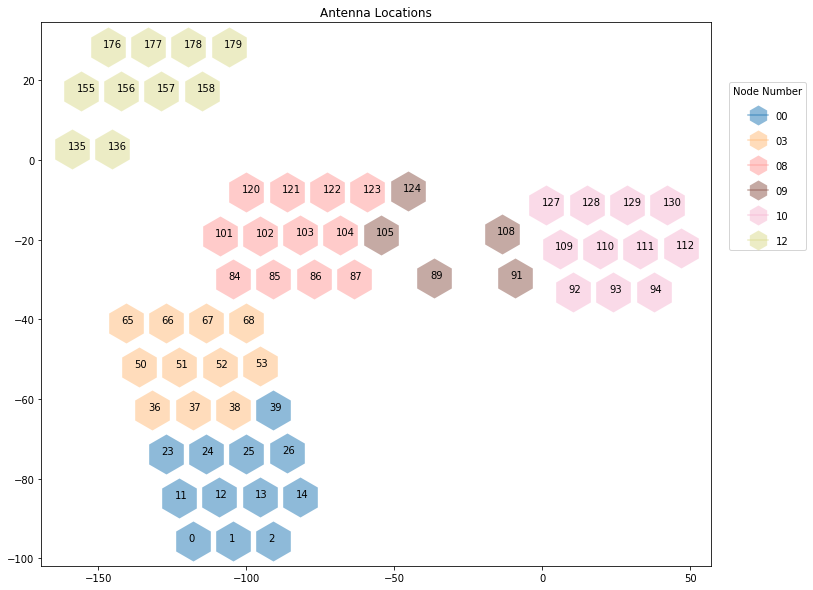

In [10]:
uvd1 = UVData()
uvd1.read(HHfiles[5], skip_bad_files=True)
utils.plot_antenna_positions(uvd1, badAnts=badAnts)

## LST Coverage

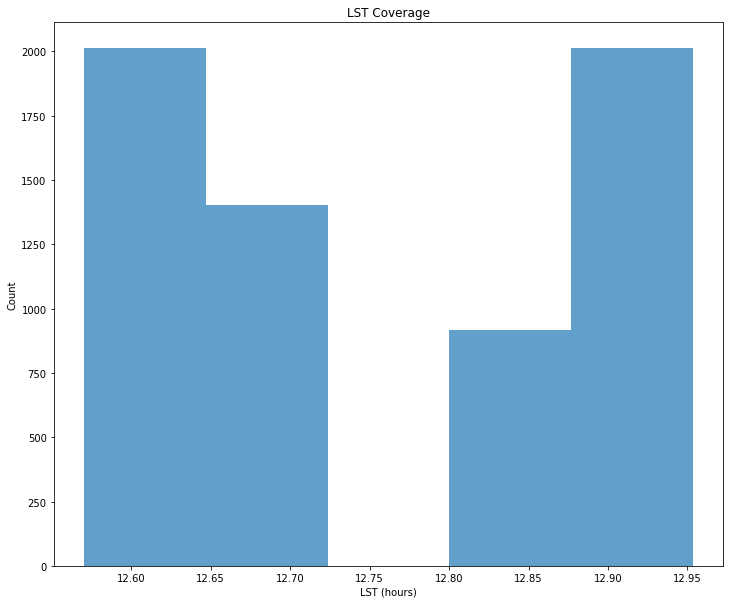

In [11]:
utils.plot_lst_coverage(uvd)

## Delay spectrum

Delay spectrum CLEANed using uvtools.dspec.high_pass_fourier_filter with 7th-order Blackman-Harris window function and full frequency band. All delay spectra except for waterfalls are incoherently averaged over ~1h (if the observation is longer than 1h) with odd/even visibilities to remove noise bias.

In [12]:
bls = [(ant,ant) for ant in np.sort(uvd.get_ants())]
_data_sq, data_rs, uvd_ds, uvd_diff = utils.clean_ds(HHfiles, difffiles, bls)

KeyError: "Unable to open object (object 'ant_1_array' doesn't exist)"

Diagnosis of delay spectra for three different delay regions:

Top panel: compute delay spectrum over 250-500 ns

Middle panel: compute standard deviation ratio $\sigma_{2500-3000}/\sigma_{3000-3200}$ to see the presence of spike at 2500-3000 ns. ~1 in y-axis (dashed line) means there is no spike, and >1 may indicate the presence of spike in the region

Bottom panel: compute distance between delay spectrum and noise level at large delay (3500-4000 ns). ~0 (dashed line) means the delay spectrum can go down to the noise level

In [13]:
utils.plot_ds_diagnosis(uvd_diff, _data_sq)

NameError: name 'uvd_diff' is not defined

In [14]:
utils.plot_ds_nodes(uvd_diff, _data_sq)

NameError: name 'uvd_diff' is not defined

In [15]:
utils.plot_wfds(uvd_ds, _data_sq, 'ee')

NameError: name 'uvd_ds' is not defined

In [16]:
utils.plot_wfds(uvd_ds, _data_sq, 'nn')

NameError: name 'uvd_ds' is not defined

These plots show incoherently averaged (~1h) delay spectra, autocorrelations and clean residuals for each antenna.

Left panel: delay spectra of autocorrelations, averaged noises from diff files (|$<\tilde{\Delta}>_{\rm t}$|, thiner fluctuating lines). The variance of the delay spectrum is also shown ($\sqrt{<|\tilde{\Delta}|^2>_{\rm t}/(2N_{\rm t})}$) which is consistent with the average of diff. Three shaded zones are those explained in the above diagnosis plots.
    
Top right: autocorrelations w/o and w/ flagging. Autocorrelations are normalized to have median=1. Flagged ones are shifted for clarity.
    
Bottom right: clean residuals normalized by the autocorrelations. If there are unflagged RFIs, which may affect the delay spectrum, we may see remaining RFI more clearly in the plot.

In [17]:
utils.plot_ds(uvd_ds, uvd_diff, _data_sq, data_rs)

NameError: name 'uvd_ds' is not defined

In [18]:
bls_cr = [(uvd.get_ants()[0],ant) for ant in np.sort(uvd.get_ants())][1:]
_data_sq_cr, data_rs_cr, uvd_cr, uvd_diff_cr = utils.clean_ds(HHfiles, difffiles, bls_cr)

KeyError: "Unable to open object (object 'ant_1_array' doesn't exist)"

Waterfalls for delay spectrum of crosscorrelation with a reference antenna

In [19]:
utils.plot_wfds_cr(uvd_cr, _data_sq_cr, 'ee')

NameError: name 'uvd_cr' is not defined

In [20]:
utils.plot_wfds_cr(uvd_cr, _data_sq_cr, 'nn')

NameError: name 'uvd_cr' is not defined

## Single File Antenna Metrics

Ant Metrics for /mnt/sn1/zen.2458925.27635.sum.ant_metrics.hdf5


KeyError: (142, 'n')

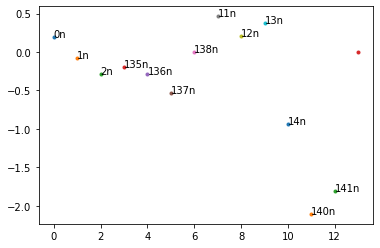

In [21]:
antmetfiles = sorted(glob.glob('{0}/zen.*.*.hdf5'.format(data_path)))
ant_metrics = hera_qm.ant_metrics.load_antenna_metrics(antmetfiles[1])
utils.show_metric(ant_metrics, antmetfiles, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel='')

## Antenna Metrics Over a Whole Night

In [22]:
utils.all_ant_mets(antmetfiles, HHfiles)

KeyError: "Unable to open object (object 'Header' doesn't exist)"